**TODO**
- just the general stuff

In [1]:
#Library import statements

from skidl.pyspice import *
#can you say cheeky 
import PySpice as pspice
#becouse it's written by a kiwi you know
import lcapy as kiwi

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

from IPython.display import YouTubeVideo, display

import traceback

In [2]:
#notebook specific loading control statements 
%matplotlib inline
#tool to log notebook internals
#https://github.com/jrjohansson/version_information
%load_ext version_information
%version_information skidl, PySpice,lcapy, sympy, numpy, matplotlib, pandas, scipy

Software,Version
Python,3.7.6 64bit [GCC 7.3.0]
IPython,7.12.0
OS,Linux 4.19.104 microsoft standard x86_64 with debian bullseye sid
skidl,0.0.31.dev0
PySpice,1.4.3
lcapy,0.70
sympy,1.6.2
numpy,1.18.1
matplotlib,3.3.0
pandas,1.1.4


In [3]:
from DC_1_Codes import get_skidl_spice_ref

# DC Sweeps 
In the last two sections, we worked with SPICE operating point analysis (.op) which just gives us static values for everything in the circuit. While this is handy for getting values it's not really that useful. What is more useful is seeing some kind of "dynamic" response of the circuit. If you know anything about SPICE you might be thinking of Transient simulations, but that is to come. Right now we want to look at the DC response of the circuit to some swept value in the circuit. To do this we use the DC simulation in ngspice (`.dc`) to shift the value of one of the elements in the circuit. Technically as of writing this ngspice (vs33) ` .dc` can sweep two values at the same time but the results are interlaced results and it's just worth doing when we can pay a slight speed penalty for using python tools like xarray to look for relations resulting from N number of individual variable sweeps. (Also as of the time of writing this pyspice will not sweep anything other than voltage and current sources, this is on my list of things to fix since ngspice by its self can sweep more than just voltage and current sources)

To illustrate DC sweeps and also to present SKiDl's subcircuit feature (more on that below) we look at Ideal vs Non-Ideal sources response to load effects. The example circuits  are based on the examples from  ALL ABOUT ELECTRONICS "Ideal Voltage Source vs. Practical Voltage Source" and “Ideal Current Source vs. Practical Current Source” that gives a good review of ideal vs non-ideal sources


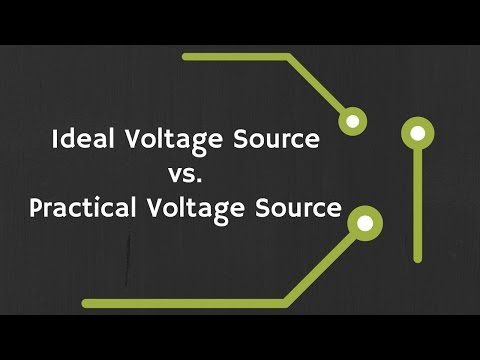

In [4]:

YouTubeVideo('TRzpqHwb-5Y', width=500, height=400, start=306)

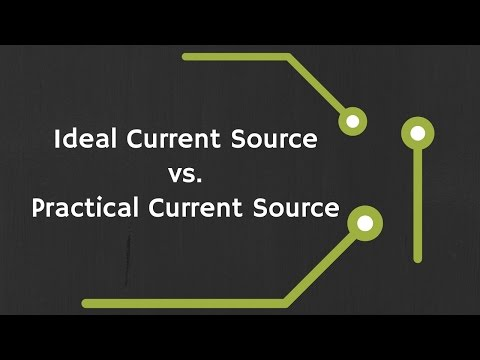

In [5]:
#@~5min
YouTubeVideo('dTf1h_xhHng', width=500, height=400, start=173)

# DC load sweep of an Ideal Voltage source

So the first thing is we create a circuit just like we would for an operating point simulation previously. And even though we are going to be sweeping values in our elements we must give all elements initial values, even if they're not in our sweep range.

In [6]:
reset()
vs=V(ref='_vs', dc_value=30@u_V)

dummy_load=I(ref='dload', dc_value=1@u_A)

gnd & vs['n', 'p']  & dummy_load['p', 'n'] & gnd
circ=generate_netlist()
print(circ)

.title 
V_vs N_1 0 30V
Idload N_1 0 1A




No errors or warnings found during netlist generation.



The next thing we do is create a pyspice simulation object just like we would do for an operating point analysis to give us access to ngspice and from which we call the DC simulation from. In the following cell, we invoke the .dc simulation on the second line. The general syntax for which is
```
<pyspice sim obj>.dc(<SPICE netlist element name to sweep>=slice(<sweep stating value>, <sweep noninclusive ending value>, <sweep step size>))
```
.dc is the method call and it uses pythons kwargs to accepts the SPICE netlist element full reference that we intend to sweep. So that in this case we are sweeping `dummy_load` as our current draw on the voltage source, and its netlist entry is `Idload`. So we pass Idload as the keyword argument to `.dc`. Then we set the value of the argument using pythons' built-in `slice` function. If you have never used it before it's a way of setting list indexing to a variable and in this case, passing list indexing through a stack. Here is a quick example that you can see `slice` in action for yourself

```
a_array=np.linspace(0, 100)
a_slice=slice(8, 15, 3) #start at item 8, up to item 15, by 3 items
(a_array[8:15:3]==a_array[a_slice]).all()
```
Back to doing a `.dc` sim, we want to sweep our load dummy_load that will draw from 0A up to 1000A (not including) with a step size of 0.1A and see what effect it has on the source. So our code will be

```
dc_vals=sim.dc(Idload=slice(0, 1000, 0.1))
```
where `dc_vals` is just the simulation results, just like an operating point analysis.


In [7]:
sim=circ.simulator()
dc_vals=sim.dc(Idload=slice(0, 10, 0.1))

Our results are accessed just like the results of an operating point analysis expect two things. One we get arrays of results for each item measured instead of just a float. Though we could get a single value if we set the .dc to only capture one point. And secondly, we have a new access `.sweep` that stores the value of the sweep variable. This means that the value at any index of the `.sweep` returned array is the circuit measured response to the sweep value at that same index.

And since we now have arrays of results we can start to do plotting. Where for this example we are going to store our voltage and current results from the simulations. Where the current is going to be the swept value. And then plot the two on an I-V plot. Whereas expected the voltage at the output of our source is unaffected by the load current.


Text(0.5, 1.0, 'Ideal Voltage Source response to any load')

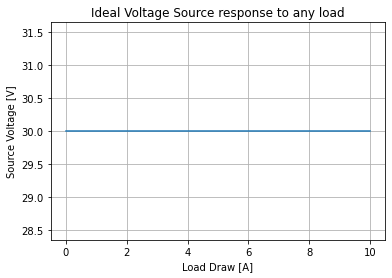

In [8]:
iv_voltage=dc_vals[node(dummy_load['p'])].as_ndarray()
iv_current=dc_vals.sweep.as_ndarray()
plt.plot(iv_current, iv_voltage)
plt.xlabel('Load Draw [A]'); plt.ylabel('Source Voltage [V]')
plt.grid()
plt.title('Ideal Voltage Source response to any load')

# A Better `.dc` Sim Interaction¶
So as we saw that was tedious. And we have already abstracted operating point analysis away in the previous sections. So using what we leaned doing that abstraction combined with what we have just learned about how a `.dc` simulation works in contrast to a `.op` we can abstract via the following steps:
1.	create the ngspice simulation access object
2.	get the element we want to sweep SPICE name
3.	construct our sweep via a slice
4.	perform the .dc simulation
5.	get results into more accessible structures
6.	(extra) create a quick plot tool

Below we accomplished that with the following class


In [9]:
#%%writefile -a DC_1_Codes.py

#chapter 1 section 3 dc_ease class
# class to perform easily perform DC sweep simulations
#gets both branch currents/node voltages and also internal parameters

class dc_ease():
    """
    Class to perform DC (.dc) SPICE simulation with some grace; only does single variable
    and is currently limited to what +variable pyspice supports
    
    TODO:
        make so that it can iterate over all filled in entries in `self.sweep_DF` and
        exports data to xarray
        
        
    """
    def __init__(self, circ_netlist_obj):
        """
        Class to perform DC (.dc) SPICE simulation with some grace; only does single variable
        and is currently limited to what variable pyspice supports
        
        Args:
            circ_netlist_obj (pspice.Spice.Netlist.Circuit): the Netlist circuit produced 
                from SKiDl's `generate_netlist()`
        
        Returns: 
            creates a table of variables that could be swept in `self.sweep_DF`
            this table will still need to be filled out for a single variable to be swept
        
        TODO: add kwargs to pass to sim creation

        """
        #need to add assertions for op_sim_circ ==pspice.Spice.Netlist.Circuit
        self.circ_netlist_obj=circ_netlist_obj
        
        self._build_table()
    
    def _build_table(self):
        """
        protected method to create `self.sweep_DF` dataframe of all things in the
        the circuit that can be swept; currently that is only voltage and current sources
        
        TODO:
            -when pyspice accepts more things to sweep add them below
        """
        
        self.sweep_DF=pd.DataFrame(columns=['Element', 'Start', 'Stop', 'Step'])
        
        for e in self.circ_netlist_obj.element_names:
            if e[0] in ['V', 'I']:
                self.sweep_DF.at[len(self.sweep_DF), 'Element']=e
        
        #convert ELmenet to index
        self.sweep_DF.set_index('Element', drop=True, append=False, inplace=True, verify_integrity=False)
    

        
    def clean_table(self):
        """
        Helper method to clean `self.sweep_DF` of any rows that are not to going to be swept
        """
        self.sweep_DF.dropna(axis=0, how='any', inplace=True)
        
    def addback_elements_2table(self):
        """
        Helper method to return empty rows to `self.sweep_DF` to manually then add sweep info to
        uses `self._build_table` to rebuild the table
        """
        for e in self.circ_netlist_obj.element_names:
            if e not in self.sweep_DF.index:
                self.sweep_DF.at[e, :]=np.nan
    
    #so ngspice is only 2d sweeps and so need figurer this out to do 2d sets
    #but will, for now, do sets of 1d
    #def _make_sim_control(self):
    #    self.clean_table()
    #    
    #    #for now dc sim through pyspice only support voltage and current sources
    #    self.dc_contorl={row[0]: slice(row[1], row[2], row[3]) for row in self.sweep_DF.itertuples() if row[0][0] in ['V', 'I']}
    
    
    def _make_sim_control(self, varible):
        """
        Internal method to extract the row information to the .dc kargs and slice argument
        
        Args:
            varible (str): the index in `self.sweep_DF` to exstract the info from
            
        Returns:
            `self.dc_contorl` what is feed into the .dc to do the simulation for a single var
            
        """
        #clean the table
        self.clean_table()
        #get the location of the variable's index
        try:
            row=self.sweep_DF.index.get_loc(varible)
            #get said row
            row=self.sweep_DF.iloc[row]
            #need to fix this in pyspice to make it fully ngspice capale
            if row.name[0] not in ['I', 'V']:
                raise KeyError
            
            #build the control
            self.dc_contorl={row.name:slice(row.Start, row.Stop, row.Step)}
            
            return 0
            
        except KeyError:
            print(f' Variable: {varible} is not in or able self.sweep_DF to be swept ')
            
            return 1
    
    def do_dc_sim(self, varible):
        """
        Does a standard Branch and Node .dc simulation for a single filled out row in `self.sweep_DF`
        
        Args:
            variable (str): the index in `self.sweep_DF` that corresponds to the thing to sweep in the .dc simulation
        
        Returns: 
            raw results are stored in `self.dc_vals`, processed results are automatically stored in 
            `self.dc_resultsNB_DF` via `self.record_dc_nodebranch`
        """
        
        
        if self._make_sim_control(varible)==0:
            self.sim=self.circ_netlist_obj.simulator()
            self.dc_vals=self.sim.dc(**self.dc_contorl)
            
            self.record_dc_nodebranch(varible)
        
        else:
            pass
                
        
    
    def record_dc_nodebranch(self, varible):
        """ 
        Helper method to put .dc node branch results into a dataframe where the index is the  variable
        
        Args:
            variable (str): used to set the index name
        
        Returns:
            `self.dc_resultsNB_DF` which is a pandas dataframe with the index being the sweep and the columns being
            the node voltages and branch currents from any available voltage sources
            
        TODO:
            get the current in any current sources
            
        """
        self.dc_resultsNB_DF=pd.DataFrame(index=self.dc_vals.sweep.as_ndarray())
        
        self.dc_resultsNB_DF.index.name=varible
        
        #get node voltages:
        
        for n in self.circ_netlist_obj.node_names:
            if n=='0':
                continue
            self.dc_resultsNB_DF[n+'_[V]']=self.dc_vals[n].as_ndarray()
        
        #get the current from any voltage sources:
        for cm in self.circ_netlist_obj.element_names:
            if 'V'==cm[0]:
                self.dc_resultsNB_DF[cm+'_[A]']=-self.dc_vals[cm].as_ndarray()
    
    def do_dc_intsim(self, varible):
        """
        Does a .dc simulation the internal variables for  a single filled out row in `self.sweep_DF`
        Right now the internal variables gathered are:
        current, voltage power for: VCCS VCVS, CCVS, CCCS, Independent current source 
        current and power for Resistors and independent voltage sources
        
        Args:
            variable (str): the index in `self.sweep_DF` that corresponds to the thing to sweep in the .dc simulation
        
        Returns: 
            raw results are stored in `self.dc_resultsINT_DF`, processed results are automatically stored in 
            `self.dc_resultsNB_DF` via `self.record_dc_internals`
        """
        
        
        self.save_internals=[]
        
        for e in self.circ_netlist_obj.element_names:
            if e[0]=='R':
                self.save_internals+=[f'@{e}[i]', f'@{e}[p]']
            
            elif e[0]=='I':
                self.save_internals+=[f'@{e}[c]', f'@{e}[v]', f'@{e}[p]']
            
            elif e[0]=='V':
                self.save_internals+=[f'@{e}[i]', f'@{e}[p]']
            
            elif e[0] in ['F', 'H', 'G', 'E']:
                self.save_internals+=[f'@{e}[i]', f'@{e}[v]', f'@{e}[p]']
        
        if self._make_sim_control(varible)==0:
            self.sim=self.circ_netlist_obj.simulator()
            self.sim.save_internal_parameters(*self.save_internals)
            self.dc_vals=self.sim.dc(**self.dc_contorl)
            
            self.record_dc_internals(varible)
    
    def record_dc_internals(self, varible):
        """ 
        Helper method to put .dc internal variable results into a dataframe where the index is the  variable
        
        Args:
            variable (str): used to set the index name
        
        Returns:
            `self.dc_resultsINT_DF` which is a pandas dataframe with the index being the sweep and the columns being
            the saved internal variables
            
        """
        self.dc_resultsINT_DF=pd.DataFrame(index=self.dc_vals.sweep.as_ndarray())
        self.dc_resultsINT_DF.index.name=varible

        
        for i in self.save_internals:
            if i[1]=='I' and i[-2]=='c':
                result_name=i[1:]+'_[A]'
            
            elif i[-2]=='i':
                result_name=i[1:]+'_[A]'
            
            elif i[-2]=='v':
                result_name=i[1:]+'_[V]'
            
            elif i[-2]=='p':
                result_name=i[1:]+'_[W]'
            
            #deal with the fliped current for voltage sources even internally
            if i[1]=='V' and i[-2]=='i':
                self.dc_resultsINT_DF[result_name]=-self.dc_vals[i].as_ndarray()
            else:
                self.dc_resultsINT_DF[result_name]=self.dc_vals[i].as_ndarray()
            
    
    def quick_plot(self, nodebranch_int_cont='nb'):
        """
        Creates a quick plot of all columns with respect to the index for the data stored in 
        `self.dc_resultsNB_DF` or `self.dc_resultsINT_DF`. Note that for larger cirucits
        these plots can have a ridicules number of subplots so yeah there is a reason for this
        methods name
        
        Args:
            nodebranch_int_cont (str; 'nb'): control word for wither to plot the node branch data ('nb')
                or the internal data ('int')
        
        Returns:
            Creates a rudimentary plot sharing a common x axis correspond the index
            for the data source and subplot row for each column in the data source
        
        """
        
        assert nodebranch_int_cont in ['nb', 'int'], f'{nodebranch_int_cont} in not a allowed control statment'
        #add a check for existence
        
        if nodebranch_int_cont=='nb':
            plotDF=self.dc_resultsNB_DF
        elif nodebranch_int_cont=='int':
            plotDF=self.dc_resultsINT_DF
        
        
        plotDF.plot(subplots=True, sharex=True, grid=True)
        # won't work for a data source with lots of columns
        plt.tight_layout()


So now let's walk through using our nee tool and make sure we can get the same results. Pro tip: you can write as many docstrings as you want (and definitely should) but walk-through examples are worth a lot more to both you hours after you write the code and to the person who is picking up the code from you.

In [10]:
# instantiate the class instance and pass in the circuit under test (DUT)
dc_sweep=dc_ease(circ)
#get the created control dataframe this is `self.sweep_DF`
dc_sweep.sweep_DF

,Start,Stop,Step
Element,,,
V_vs,NaN,NaN,NaN
Idload,NaN,NaN,NaN


As stated we create a dataframe that holds all the things we can sweep that we have to fill out. Because we only simulate the results of sweeping one variable at a time this allows us to have some kind of ledger of things we want to sweep. To set the values we use the index and pandas `.at` accessor to give each row it's starting, stopping, and step value.

In [11]:
dc_sweep.sweep_DF.at['Idload']=0, 10, 0.1
dc_sweep.sweep_DF

,Start,Stop,Step
Element,,,
V_vs,NaN,NaN,NaN
Idload,0,10,0.1


In [12]:
dc_sweep.sweep_DF.at['V_vs']=0, 10, 0.1
dc_sweep.sweep_DF

,Start,Stop,Step
Element,,,
V_vs,0,10,0.1
Idload,0,10,0.1


The thing about testing either code or our circuit is that to truly verify functionally it's not good enough to test just what something is supposed to do but also test to make sure it shouldn't do things we know it shouldn't do. So let's tell `dc_sweep` to do a simulation on a variable not in the control structure `dc_sweep.sweep_DF`

In [13]:
dc_sweep.do_dc_sim('Rload')

 Variable: Rload is not in or able self.sweep_DF to be swept 


And we see that it indeed threw and caught a key error since `Rload` is not an index in `dc_sweep.sweep_D`F as we intended in `dc_sweep._make_sim_control`. If this was production code we would be looping all sorts of tests against this to verify this code's performance before we even let it try to verify any circuits under test. But functional verification of code is not the goal of this book but is a subject the reader should study.
Let's now have it sweep the dummy load as we did manually and make sure we get the same results, as we should since we are using the same circuit.

In [14]:
dc_sweep.do_dc_sim('Idload')
dc_sweep.dc_resultsNB_DF

,N_1_[V],V_vs_[A]
Idload,,
0.0,30.0,-0.0
0.1,30.0,0.1
0.2,30.0,0.2
0.3,30.0,0.3
0.4,30.0,0.4
...,...,...
9.6,30.0,9.6
9.7,30.0,9.7
9.8,30.0,9.8


And indeed, we get what we got manually, now let us do this again for the internals. But since the internals were not simulated when we did this manually, we must use our EE knowledge to still do the sanity check. In this cause is obvious that the voltage through the current source that serves as our load should always be 30V where the sign is flipped because SPICE.

In [15]:
dc_sweep.do_dc_intsim('Idload')
dc_sweep.dc_resultsINT_DF

Unit is None for @v_vs[p] power
Unit is None for @idload[p] power


,V_vs[i]_[A],V_vs[p]_[W],Idload[c]_[A],Idload[v]_[V],Idload[p]_[W]
Idload,,,,,
0.0,-0.0,-0.0,0.0,-30.0,0.0
0.1,0.1,3.0,0.1,-30.0,3.0
0.2,0.2,6.0,0.2,-30.0,6.0
0.3,0.3,9.0,0.3,-30.0,9.0
0.4,0.4,12.0,0.4,-30.0,12.0
...,...,...,...,...,...
9.6,9.6,288.0,9.6,-30.0,288.0
9.7,9.7,291.0,9.7,-30.0,291.0
9.8,9.8,294.0,9.8,-30.0,294.0


We clearly see `False` results so we need to sanity check these. When dealing with programmatic data analysis eyeball sanity checks are still an effort-saving practice.  So let’s isolate the failing rows real quick since that is part of the power of having Python interact with SPICE is this kind of data handling ease.

In [16]:
dc_sweep_int_data=dc_sweep.dc_resultsINT_DF
dc_sweep_int_data['Idload[A]_calc']=(dc_sweep_int_data['Idload[p]_[W]']/-dc_sweep_int_data['Idload[v]_[V]'])
dc_sweep_int_data['Test']=(dc_sweep_int_data['Idload[A]_calc']==dc_sweep_int_data.index)
dc_sweep_int_data

,V_vs[i]_[A],V_vs[p]_[W],Idload[c]_[A],Idload[v]_[V],Idload[p]_[W],Idload[A]_calc,Test
Idload,,,,,,,
0.0,-0.0,-0.0,0.0,-30.0,0.0,0.0,True
0.1,0.1,3.0,0.1,-30.0,3.0,0.1,True
0.2,0.2,6.0,0.2,-30.0,6.0,0.2,True
0.3,0.3,9.0,0.3,-30.0,9.0,0.3,True
0.4,0.4,12.0,0.4,-30.0,12.0,0.4,True
...,...,...,...,...,...,...,...
9.6,9.6,288.0,9.6,-30.0,288.0,9.6,True
9.7,9.7,291.0,9.7,-30.0,291.0,9.7,True
9.8,9.8,294.0,9.8,-30.0,294.0,9.8,True


In [17]:
dc_sweep_int_data[dc_sweep_int_data['Test']==False]

,V_vs[i]_[A],V_vs[p]_[W],Idload[c]_[A],Idload[v]_[V],Idload[p]_[W],Idload[A]_calc,Test
Idload,,,,,,,
2.3,2.3,69.0,2.3,-30.0,69.0,2.3,False
3.9,3.9,117.0,3.9,-30.0,117.0,3.9,False
4.9,4.9,147.0,4.9,-30.0,147.0,4.9,False
5.7,5.7,171.0,5.7,-30.0,171.0,5.7,False
6.5,6.5,195.0,6.5,-30.0,195.0,6.5,False
7.3,7.3,219.0,7.3,-30.0,219.0,7.3,False


 So why are these rows failing, while it helps to look at a single row since the display of a full table can hide information for presentation sakes. 

In [18]:
dc_sweep_int_data.iloc[-1]

V_vs[i]_[A]         10
V_vs[p]_[W]        300
Idload[c]_[A]       10
Idload[v]_[V]      -30
Idload[p]_[W]      300
Idload[A]_calc      10
Test              True
Name: 9.99999999999998, dtype: object

We see instantly that the issue is that since SPICE uses things RK45 solvers and works with near arbitrarily small currents, it is going to report extremely precise values so that inputs, for lack of a better word, yield "jittery" results. So then we have to use some exploratory data analysis skills along with knowing when SPICE is giving us overkill answers to clarify this. Since we know SPICE is giving us overkill on the input and we don't care in this simulation for any values beyond 4 decimals (really 2 decimals) so that applying `np.around` allows equal value reporting between our swept current and measured current.

In [19]:
dc_sweep_int_data.index=np.around(dc_sweep_int_data.index, 4)
dc_sweep_int_data['Idload[A]_calc']=np.around(dc_sweep_int_data['Idload[A]_calc'], 4)
dc_sweep_int_data['Test']=(dc_sweep_int_data['Idload[A]_calc']==dc_sweep_int_data.index)
dc_sweep_int_data

,V_vs[i]_[A],V_vs[p]_[W],Idload[c]_[A],Idload[v]_[V],Idload[p]_[W],Idload[A]_calc,Test
Idload,,,,,,,
0.0,-0.0,-0.0,0.0,-30.0,0.0,0.0,True
0.1,0.1,3.0,0.1,-30.0,3.0,0.1,True
0.2,0.2,6.0,0.2,-30.0,6.0,0.2,True
0.3,0.3,9.0,0.3,-30.0,9.0,0.3,True
0.4,0.4,12.0,0.4,-30.0,12.0,0.4,True
...,...,...,...,...,...,...,...
9.6,9.6,288.0,9.6,-30.0,288.0,9.6,True
9.7,9.7,291.0,9.7,-30.0,291.0,9.7,True
9.8,9.8,294.0,9.8,-30.0,294.0,9.8,True


In [20]:
dc_sweep_int_data[dc_sweep_int_data['Test']==False]

,V_vs[i]_[A],V_vs[p]_[W],Idload[c]_[A],Idload[v]_[V],Idload[p]_[W],Idload[A]_calc,Test
Idload,,,,,,,


And finally we need to test every future so lets make the quick plots.

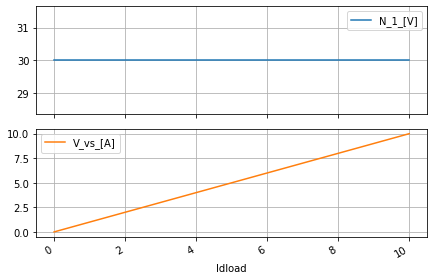

In [21]:
dc_sweep.quick_plot()

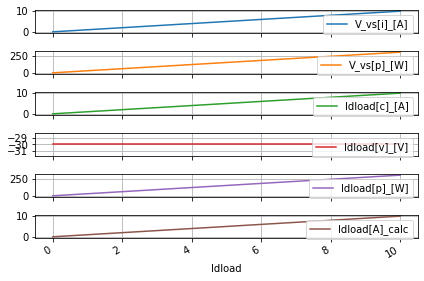

In [22]:
dc_sweep.quick_plot('int')

# Ideal Current Source¶
Since we are talking about ideal vs non-ideal sources, we should look at the current complement to the voltage case and use our new tool to automate as much as we can.

In [23]:
reset()
cs=I(ref='_cs', dc_value=10@u_mA)

dummy_drop=V(ref='ddrop', dc_value=1@u_V)

cs['p']+=gnd
#ideal_rpar[1, 2]+=cs['n'], gnd
dummy_drop['p', 'n']+=cs['n'], gnd

circ=generate_netlist()
print(circ)

.title 
I_cs 0 N_1 10mA
Vddrop N_1 0 1V




No errors or warnings found during netlist generation.



In [24]:
dc_sweep=dc_ease(circ)
dc_sweep.sweep_DF

,Start,Stop,Step
Element,,,
I_cs,NaN,NaN,NaN
Vddrop,NaN,NaN,NaN


In [25]:
dc_sweep.sweep_DF.at['Vddrop']=0, 10, 0.1
dc_sweep.do_dc_intsim('Vddrop')
ideal_cur_res=dc_sweep.dc_resultsINT_DF

Unit is None for @i_cs[p] power
Unit is None for @vddrop[p] power


In [26]:
ideal_cur_res

,I_cs[c]_[A],I_cs[v]_[V],I_cs[p]_[W],Vddrop[i]_[A],Vddrop[p]_[W]
Vddrop,,,,,
0.0,0.01,0.0,-0.000,-0.01,-0.000
0.1,0.01,0.1,-0.001,-0.01,-0.001
0.2,0.01,0.2,-0.002,-0.01,-0.002
0.3,0.01,0.3,-0.003,-0.01,-0.003
0.4,0.01,0.4,-0.004,-0.01,-0.004
...,...,...,...,...,...
9.6,0.01,9.6,-0.096,-0.01,-0.096
9.7,0.01,9.7,-0.097,-0.01,-0.097
9.8,0.01,9.8,-0.098,-0.01,-0.098


Before we get to the plot, let discuss something. There are two schools of thought when plotting things in EE. The first school is that the independent variable should be on the x-axis and the dependent variables should be on the y axis. The other school of thought is when comparing apples to oranges pick an axis convention and stick with it. In this book, we use both since it just a matter of context, and plots are cheap to make with a computer. For comparing voltage sources and current sources were going with the "apples to oranges" convention. But beware when doing this you need to make your axis labels explicit as to what are the independent and dependent variables for each plot that is made.

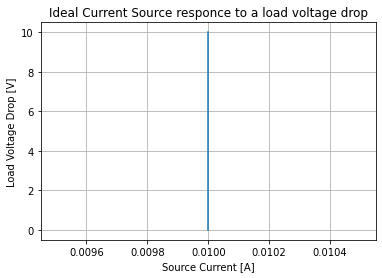

In [27]:
plt.plot(ideal_cur_res['I_cs[c]_[A]'], ideal_cur_res.index)
plt.xlabel('Source Current [A]'); plt.ylabel('Load Voltage Drop [V]')
plt.grid()
plt.title('Ideal Current Source responce to a load voltage drop');

# First testbench element¶

So first of all a physical testbench is setup with some way to probe signals into and out of a Device Under Test (DUT) where those signals are souced and read in by various instruments. The whole setup is called a test suite. Thus far we have been creating the test measurement tools with kladjlkadlfkjaldjk. We will get into test suite development when we combine a SPICE measurement,  analysis routine, along with a test bench built into a single tool. For now, let’s focus on creating testbenchs.

The first testbenchs we are going to build are non-ideal sources. So why in the world would we want these. While ideal sources don't exist outside of SPICE and SPICE ultimately doesn't pay the bills, the physical PCB and Silicon produced and being able to be sold pays the bills. So you better verify to what degrees your circuits can deal with less than ideal sources. Now traditionally one would have to redraw parts of the circuit to convert the ideal source to non-ideal sources and then be careful that the elements that make a source non-ideal don't get place and routed. And one would have to do this for every source, yuck! But this is Python so we can create a reusable way to generate non-ideal sources with functions or classes and then just deploy. When SKiDl gets the means to remove elements and connections the power to replace the ideal source with a non-ideal source and hook up any other sort of testbench will be immense.

So how do we create a function that will do this magic of instantly producing a simple non-ideal source lets make a testbench a non-ideal voltage source and see.


## Non-Ideal Voltage  Source Testbench¶

In [28]:
#%%writefile -a DC_1_Codes.py

#chapter 1 section 3 real_dcVs subcircuit function
# SKiDl subcirucit to create a dc voltage source with 
# added series resistor


@subcircuit
def real_dcVs(global_ref, pos_term, neg_term, starting_V=1@u_V, starting_R=50@u_Ohm, 
           return_internls=False):
    """
    SKiDl subcircuit to create a simple non-ideal DC voltage source
    
    Args:
        global_ref (str): reference to use for the base of the internal elements
        
        pos_term (SKiDl net or pin): positive terminal of the nonideal voltage source
            to connect to the rest of the circuit
        
        neg_term (SKiDl net or pin): negative terminal of the nonideal voltage source
            to connect to the rest of the circuit 
        
        starting_V (float; 1; Volts):the intial DC voltage to set the internal ideal
            the voltage source in this package to
        
        starting_R (float; 50; Ohm): the initial resistance to set the internal
            serial resistance to the ideal voltage source in this subcircuit to
        
        return_internls (bool; False): If True return out the internal Voltage Source,
            and Resistance objects in this package
    
    Returns:
        Returns it's self a SKiDl part element object and if `return_internls`
        is True will return the internal voltage and resistance objects in that order 
    """
    vs=V(ref=f'V_{global_ref}', dc_value=starting_V)
    rs=R(ref=f'R_{global_ref}', value=starting_R)
    
    vs['p', 'n']+=rs[1], neg_term
    rs[2]+=pos_term
    
    if return_internls:
        return vs, rs


The first line of code `@subcircuit` is called a decorator and for our purposes, it just says to Python that whatever function we wite below the decorator is imbued with enhancements defined by `@subcircuit` definition in SKiDl.

Then for our function arguments, we use a lot of generic arguments for things like voltage, resistance, and the base name of the elements in our subcircuit. But for a subcircuit to be a subcircuit, it must connect to the rest of the circuit. So we need to have arguments that will act as pass-throughs for a net connection to be made to where we want our external terminals to be. In this case, we have two terminals. The positive one `pos_term` acts as the terminal to our positive output at the end of the subcircuit’s series resistors `rs`. And neg_term is the corresponding terminal to the negative side of the subcircuit’s `vs`. Now for this testbench subcircuit, we have also included a control `return_internls` to return the internal created objects so that we can grab them in python to have more refined control over them before we create the netlist. Whether we grab the internally created elements or not has no consequences on the final netlist.

In [29]:
reset()
dummy_load=I(ref='dload', dc_value=1@u_A); dummy_load['n']+=gnd

#invoke our subscript and for kicks have it return the internals to external variables
#that could be fine-tuned outside of there invocation inside the subcircuit
real_vss, real_vsr=real_dcVs('real_vs', dummy_load['p'], gnd, 30@u_V, 20@u_Ohm, True)

circ=generate_netlist()
print(circ)

dc_sweep=dc_ease(circ)
dc_sweep.sweep_DF


.title 
R_real_vs N_1 N_2 20Ohm
V_real_vs N_1 0 30V
Idload N_2 0 1A




No errors or warnings found during netlist generation.



,Start,Stop,Step
Element,,,
V_real_vs,NaN,NaN,NaN
Idload,NaN,NaN,NaN


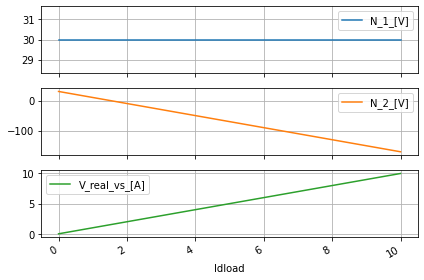

In [30]:
#perform the simulation
dc_sweep.sweep_DF.at[get_skidl_spice_ref(dummy_load)]=[0, 10, 0.1]
dc_sweep.do_dc_sim(get_skidl_spice_ref(dummy_load))
dc_sweep.quick_plot()

In [31]:
#collect the results 
real_vs_data=dc_sweep.dc_resultsNB_DF
real_vs_data

,N_1_[V],N_2_[V],V_real_vs_[A]
Idload,,,
0.0,30.0,30.0,-0.0
0.1,30.0,28.0,0.1
0.2,30.0,26.0,0.2
0.3,30.0,24.0,0.3
0.4,30.0,22.0,0.4
...,...,...,...
9.6,30.0,-162.0,9.6
9.7,30.0,-164.0,9.7
9.8,30.0,-166.0,9.8


Text(0.5, 1.0, 'Ideal and Non-Ideal Voltage Source response to load')

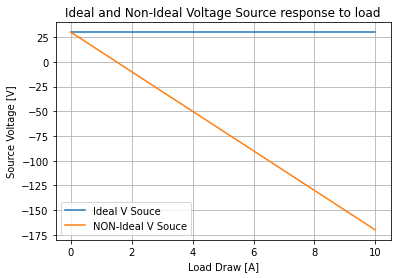

In [32]:
#make the plot
niv_voltage=real_vs_data[node(dummy_load['p'])+'_[V]']
niv_current=real_vs_data.index
#plot the old ideal voltage source
plt.plot(iv_current, iv_voltage, label='Ideal V Souce')
#plot the newly found non-ideal voltage source
plt.plot(niv_current, niv_voltage, label='NON-Ideal V Souce')

plt.xlabel('Load Draw [A]'); plt.ylabel('Source Voltage [V]')
plt.xlabel('Load Draw [A]'); plt.ylabel('Source Voltage [V]')

plt.grid()
plt.legend()
plt.title('Ideal and Non-Ideal Voltage Source response to load')


And because of the scaling, we can't really see that the ideal source is at 30V but by plotting the old and new data we can see what effect adding the serial resistance to make the voltage source non-ideal has done.

## Non-Ideal Current Source Testbench¶
It's typically a good idea if the investment is low enough to make the V-I dual to whatever you have made. So why not,  cause again this is code we can have on hand and call up whenever needed. Opposed to finding and redrawing every single source in a schematic.

In [33]:
#%%writefile -a DC_1_Codes.py

#chapter 1 section 3 real_dcIs subcircuit function
# SKiDl subcirucit to create a dc current source with 
# added parallel resistor

@subcircuit
def real_dcIs(global_ref, pos_term, neg_term, starting_I=1@u_A, starting_R=50@u_Ohm, 
           return_internls=False):
    """
    SKiDl subcircuit to create a simple non-ideal DC current source.
    Where the positive terminal is to the top of the arrow of a schematically drawn
    current source
    
    Args:
        global_ref (str): reference to use for the base of the internal elements
        
        pos_term (SKiDl net or pin): positive terminal of the nonideal voltage source
            to connect to the rest of the circuit 
        
        neg_term (SKiDl net or pin): negative terminal of the nonideal voltage source
            to connect to the rest of the circuit 
        
        starting_V (float; 1; Amps): the initial DC current to set the internal ideal
            the current source in this package to
        
        starting_R (float; 50; Ohm): the initial resistance to set the internal
            parral resistance to the ideal current source in this subcircuit to
        
        return_internls (bool; False): If True return out the internal Voltage Source,
            and Resistance objects in this package
    
    Returns:
        Returns it's self a SKiDl part element object and if `return_internls`
        is True will return the internal voltage and resistance objects in that order 
    """
    cs=I(ref=f'I_{global_ref}', dc_value=starting_I)
    rp=R(ref=f'R_{global_ref}', value=starting_R)
    
    cs['p', 'n'] | rp[2, 1]
    rp[1, 2]+=pos_term, neg_term
    
    if return_internls:
        return cs, rp


In [34]:
reset()
dummy_drop=V(ref='ddrop', dc_value=1@u_V); dummy_drop['n']+=gnd
real_css, real_csr=real_dcIs('real_cs', dummy_drop['p'], gnd, 10@u_mA, 10@u_MOhm, True)
circ=generate_netlist()
print(circ)


.title 
I_real_cs 0 N_2 10mA
R_real_cs N_2 0 10MegOhm
Vddrop N_2 0 1V




No errors or warnings found during netlist generation.



In [35]:
dc_sweep=dc_ease(circ)
dc_sweep.sweep_DF.at['Vddrop']=0, 10, 0.1
dc_sweep.do_dc_intsim('Vddrop')
nonideal_cur_res=dc_sweep.dc_resultsINT_DF
nonideal_cur_res

Unit is None for @vddrop[p] power
Unit is None for @r_real_cs[p] power
Unit is None for @i_real_cs[p] power


,I_real_cs[c]_[A],I_real_cs[v]_[V],I_real_cs[p]_[W],R_real_cs[i]_[A],R_real_cs[p]_[W],Vddrop[i]_[A],Vddrop[p]_[W]
Vddrop,,,,,,,
0.0,0.01,0.0,-0.000,0.000000e+00,0.000000e+00,-0.010000,-0.000000
0.1,0.01,0.1,-0.001,1.000000e-08,1.000000e-09,-0.010000,-0.001000
0.2,0.01,0.2,-0.002,2.000000e-08,4.000000e-09,-0.010000,-0.002000
0.3,0.01,0.3,-0.003,3.000000e-08,9.000000e-09,-0.010000,-0.003000
0.4,0.01,0.4,-0.004,4.000000e-08,1.600000e-08,-0.010000,-0.004000
...,...,...,...,...,...,...,...
9.6,0.01,9.6,-0.096,9.600000e-07,9.216000e-06,-0.009999,-0.095991
9.7,0.01,9.7,-0.097,9.700000e-07,9.409000e-06,-0.009999,-0.096991
9.8,0.01,9.8,-0.098,9.800000e-07,9.604000e-06,-0.009999,-0.097990


And the only difference in our plotting for the current source as opposed to the voltage source is that instead of setting variables for each cases voltage and current we are just calling against the resulting dataframes which has some downside from a readability standpoint but is a better practice who can be clarified with comments.

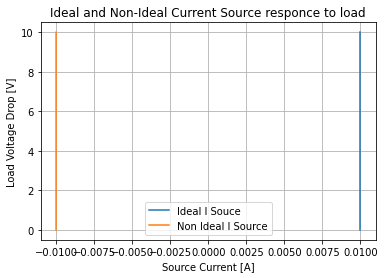

In [36]:
plt.plot(ideal_cur_res['I_cs[c]_[A]'], ideal_cur_res.index, label='Ideal I Souce')
plt.plot(nonideal_cur_res['Vddrop[i]_[A]'], nonideal_cur_res.index, label='Non Ideal I Source')
plt.xlabel('Source Current [A]'); plt.ylabel('Load Voltage Drop [V]')
plt.grid()
plt.legend()
plt.title('Ideal and Non-Ideal Current Source responce to load');

Because of the high parallel resistance inside the non-ideal current source, we see more of a translation than a tilting. Since is this reproducible code the reader should play with values and see what happens. After all, one of the goals of this book is showing how SPICE encapsulated with python can be used as an educational enhancement in teaching electronics

## Citations:
[1] ALL ABOUT ELECTRONICS. "Ideal Voltage Source vs. Practical Voltage Source
," YouTube, Jan 18, 2017. [Video file]. Available: https://youtu.be/TRzpqHwb-5Y. [Accessed: Nov 30, 2020].

[2] ALL ABOUT ELECTRONICS. "Ideal Current Source vs. Practical Current Source
," YouTube, Jan 21, 2017. [Video file]. Available: https://youtu.be/dTf1h_xhHng. [Accessed: Nov 30, 2020].